<h1 style="text-align:center; font-size:32px; font-weight:bold;">
  Bidding Model Evaluation at Criteo
</h1>

<h3 style="text-align:center; font-size:20px; font-weight:normal;">
  Prepared by <strong>Ecem Bayındır</strong>
</h3>

<br/>

<p style="font-size:16px;">
  This project investigates bidding optimization strategies for programmatic advertising at <strong>Criteo</strong>,
  using real-world-style Click-Through Rate (CTR) prediction data. The business scenario is as follows:
</p>

<ul style="font-size:16px;">
  <li>A display ad inventory of <strong>1,000 slots on CNN.com</strong> is auctioned to Criteo clients.</li>
  <li>Two brands — <strong>Hollister</strong> and <strong>Fridge</strong> — engage in bidding with different model-based strategies.</li>
  <li><strong>Linear Regression</strong> and <strong>Deep Learning</strong> models result in varying profitability, click-through behavior, and cost structures.</li>
</ul>

<p style="font-size:16px;">
  The objective is to evaluate and compare the performance of both bidding models in terms of <strong>profitability</strong>,
  <strong>prediction accuracy</strong>, and <strong>business impact</strong>. The ultimate aim is to determine the more effective strategy
  for deployment in Criteo’s production environment.
</p>

<p style="font-size:16px;">
  This project mimics an end-to-end data science workflow — including data preprocessing, feature engineering, model development,
  bidding simulation, and offline A/B testing. Since real-time experimentation infrastructure is not available,
  the A/B test was implemented as a statistical simulation using hold-out test data. The entire workflow reflects the type of analysis
  a <strong>Product Analytics – Data Scientist</strong> at Criteo would perform to support bidding model decisions.
</p>

<h2 style="font-size:20px; margin-top:30px;">Dataset Information</h2>

<p style="font-size:16px;">
  The dataset used in this project is a 30-day sample of live traffic data from Criteo’s display advertising platform.
  It includes over 16.5 million impressions, 45,000 conversions, and 700 campaigns, anonymized and pre-processed to preserve proprietary elements.
</p>

<p style="font-size:16px;">
  Each row represents a single ad impression and includes the following features:
</p>

<ul style="font-size:16px;">
  <li><code>timestamp</code>: Relative timestamp of the impression</li>
  <li><code>uid</code>: User identifier</li>
  <li><code>campaign</code>: Campaign identifier</li>
  <li><code>conversion</code>: 1 if the user converted within 30 days</li>
  <li><code>conversion_timestamp</code>: Time of conversion or -1</li>
  <li><code>conversion_id</code>: Conversion identifier or -1</li>
  <li><code>attribution</code>: 1 if attributed to Criteo</li>
  <li><code>click</code>: 1 if clicked</li>
  <li><code>click_pos</code>: Position in click sequence (0 = first click)</li>
  <li><code>click_nb</code>: Number of clicks before conversion</li>
  <li><code>cost</code>: Transformed display cost</li>
  <li><code>cpo</code>: Transformed cost-per-order</li>
  <li><code>time_since_last_click</code>: Time since last click in seconds</li>
  <li><code>cat1</code> to <code>cat9</code>: Categorical contextual features</li>
</ul>

<p style="font-size:16px;">
  🔗 <strong>Dataset Link:</strong>
  <a href="https://www.kaggle.com/datasets/sharatsachin/criteo-attribution-modeling/data" target="_blank">
    https://www.kaggle.com/datasets/sharatsachin/criteo-attribution-modeling/data
  </a>
</p>

<p style="font-size:16px;">
  This dataset is released with the following paper:<br/>
  <em>“Attribution Modeling Increases Efficiency of Bidding in Display Advertising”</em><br/>
  Eustache Diemert, Julien Meynet (Criteo AI Lab), Damien Lefortier (Facebook), Pierre Galland (Criteo)<br/>
  Published at <strong>AdKDD & TargetAd Workshop, ACM KDD 2017</strong>.
</p>


In [2]:
#STEP 1: Data Cleaning & Initial Checks

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
#1.2 Load Dataset & Inspect Basic Info

df = pd.read_csv("pcb_dataset_final.tsv", sep='\t')

print("Dataset shape:", df.shape)
print("\nColumn Types:\n", df.dtypes)
print("\nNull Values:\n", df.isnull().sum())


print("\nHead of Dataset:")
print(df.head())

Dataset shape: (16468027, 22)

Column Types:
 timestamp                  int64
uid                        int64
campaign                   int64
conversion                 int64
conversion_timestamp       int64
conversion_id              int64
attribution                int64
click                      int64
click_pos                  int64
click_nb                   int64
cost                     float64
cpo                      float64
time_since_last_click      int64
cat1                       int64
cat2                       int64
cat3                       int64
cat4                       int64
cat5                       int64
cat6                       int64
cat7                       int64
cat8                       int64
cat9                       int64
dtype: object

Null Values:
 timestamp                0
uid                      0
campaign                 0
conversion               0
conversion_timestamp     0
conversion_id            0
attribution              0
click     

In [4]:
#1.3 Check Unique Values of Key Variables

print("Unique Campaigns:", df["campaign"].nunique())
print("Unique Users:", df["uid"].nunique())
print("Unique Conversions:", df["conversion"].nunique())
print("Unique Clicks:", df["click"].nunique())

Unique Campaigns: 675
Unique Users: 6142256
Unique Conversions: 2
Unique Clicks: 2


Click-through rate: 0.3612
Conversion rate: 0.0490


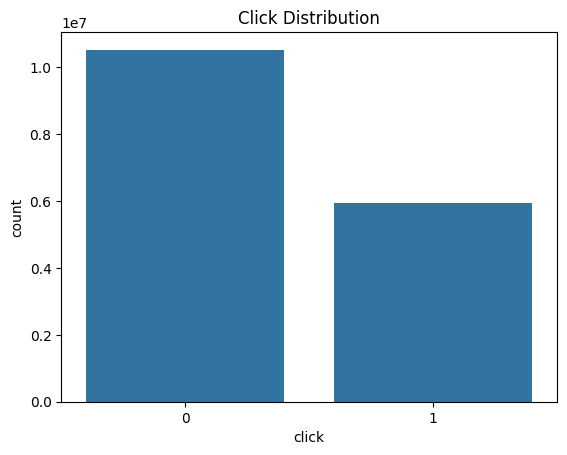

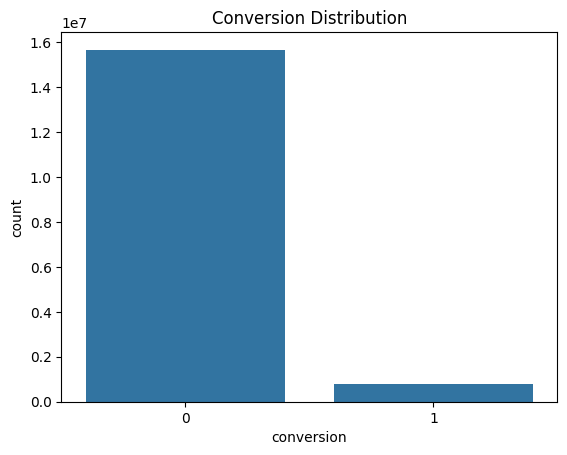

In [5]:
#1.4 Distribution of Target Variables

# Click and Conversion Distribution
click_rate = df['click'].mean()
conversion_rate = df['conversion'].mean()

print(f"Click-through rate: {click_rate:.4f}")
print(f"Conversion rate: {conversion_rate:.4f}")

# Bar plots
sns.countplot(x='click', data=df)
plt.title("Click Distribution")
plt.savefig("figures/Click Distribution.png", bbox_inches='tight')
plt.show()

sns.countplot(x='conversion', data=df)
plt.title("Conversion Distribution")
plt.savefig("figures/Conversion Distribution.png", bbox_inches='tight')
plt.show()

In [6]:
#STEP 2: Feature Exploration and Cleaning

# Check for unique values and distribution in key columns
print("Click value counts:\n", df['click'].value_counts(normalize=True))
print("\nConversion value counts:\n", df['conversion'].value_counts(normalize=True))
print("\nAttribution value counts:\n", df['attribution'].value_counts(normalize=True))
print("\nCheck for negative or invalid values in time_since_last_click:\n", df['time_since_last_click'].describe())

Click value counts:
 click
0    0.638842
1    0.361158
Name: proportion, dtype: float64

Conversion value counts:
 conversion
0    0.951045
1    0.048955
Name: proportion, dtype: float64

Attribution value counts:
 attribution
0    0.973134
1    0.026866
Name: proportion, dtype: float64

Check for negative or invalid values in time_since_last_click:
 count    1.646803e+07
mean     2.713594e+05
std      5.273109e+05
min     -1.000000e+00
25%     -1.000000e+00
50%     -1.000000e+00
75%      2.736810e+05
max      2.592000e+06
Name: time_since_last_click, dtype: float64


In [7]:
#STEP 3: Explore Categorical Features

# Count of unique values in categorical features
cat_features = [col for col in df.columns if 'cat' in col]

print("\nUnique values in categorical features:")
for col in cat_features:
    print(f"{col}: {df[col].nunique()}")


Unique values in categorical features:
cat1: 9
cat2: 70
cat3: 1829
cat4: 21
cat5: 51
cat6: 30
cat7: 57196
cat8: 11
cat9: 30


In [8]:
# STEP 4: Feature Engineering

# Replace -1 in time_since_last_click with NaN and create binary flag for first clicks
df['time_since_last_click_cleaned'] = df['time_since_last_click'].replace(-1, np.nan)
df['is_first_click'] = (df['time_since_last_click'] == -1).astype(int)

# Frequency encoding for high cardinality categorical variables
for col in ['cat2', 'cat3', 'cat7']:
    freq_map = df[col].value_counts(normalize=True)
    df[f'{col}_freq'] = df[col].map(freq_map)

# Drop high cardinality original features (to avoid memory-heavy one-hot encoding)
df_linreg = df.drop(columns=['cat2', 'cat3', 'cat7'])

# Final columns included for modeling (Linear Regression / Logistic Regression)
print("Updated columns for modeling:\n")
print(df_linreg.columns.tolist())

Updated columns for modeling:

['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp', 'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb', 'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat4', 'cat5', 'cat6', 'cat8', 'cat9', 'time_since_last_click_cleaned', 'is_first_click', 'cat2_freq', 'cat3_freq', 'cat7_freq']


In [9]:
# STEP 5: Preprocessing + Train/Validation/Test Split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [10]:
# --- Step 1: Sample 1,000,000 rows stratified by target
target = 'click'

df_sample, _ = train_test_split(
    df_linreg,
    train_size=1_000_000,
    stratify=df_linreg[target],
    random_state=42
)

print("Sampled data shape:", df_sample.shape)
print("Sample CTR:", df_sample['click'].mean())

Sampled data shape: (1000000, 24)
Sample CTR: 0.361158


In [11]:
# --- Step 2: Feature definitions
features = [col for col in df_sample.columns if col not in [
    'click', 'conversion', 'conversion_timestamp', 'conversion_id',
    'attribution', 'uid', 'campaign', 'timestamp'
]]

X = df_sample[features]
y = df_sample[target]

In [12]:
# --- Step 3: Identify column types
categorical_cols = ['cat1', 'cat4', 'cat5', 'cat6', 'cat8', 'cat9']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

In [13]:
# --- Step 4: Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [14]:
# --- Step 5: Split into train (70%), validation (10%), and test (20%)
# First split off test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Now split the remaining 80% into train (70%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42
    # 0.125 * 0.8 = 0.1 of total → validation set
)

In [15]:
# --- Step 6: Output shapes
print("Training size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Training size: (700000, 16)
Validation size: (100000, 16)
Test size: (200000, 16)


In [16]:
# STEP 6: Linear Regression Bidding Model with Validation and Accuracy Comparison

from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    f1_score, classification_report, confusion_matrix, accuracy_score
)

In [17]:
# --- Step 1: Train the pipeline
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
linear_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['click_pos', 'click_nb',
                                                   'cost', 'cpo',
                                                   'time_since_last_click',
                                                   'time_since_last_click_cleaned',
                                                   'is_first_click',
                                                   'cat2_freq', 'cat3_freq',
                                                   'cat7_freq']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cat1', 'cat4', 'cat5',
                                                   'cat6', 'cat8', 'cat9'])])),
                ('regressor', LinearRegression())])

In [18]:
# --- Step 2: Predict on train, validation and test sets
train_pred = linear_pipeline.predict(X_train)
val_pred = linear_pipeline.predict(X_val)
test_pred = linear_pipeline.predict(X_test)

In [19]:

# --- Step 3: Evaluation function for regression
import re

def evaluate_regression_model(name, y_true, y_pred):
    print(f"\n📈 {name} - Regression Evaluation Metrics:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"Mean Squared Error: {mean_squared_error(y_true, y_pred):.6f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_true, y_pred):.6f}")
    plt.figure(figsize=(8, 5))
    sns.histplot(y_pred, bins=50, kde=True)
    plt.title(f'Predicted CTR Distribution ({name})')
    plt.xlabel('Predicted CTR')
    plt.ylabel('Frequency')
    plt.grid(True)
    # Sanitize name to create a valid file name
    safe_name = re.sub(r'[^a-zA-Z0-9_ -]', '', name).replace(' ', '_')
    filename = f"figures/Predicted_CTR_Distribution_{safe_name}.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


📈 Linear Regression (Train) - Regression Evaluation Metrics:
R² Score: 0.1127
Mean Squared Error: 0.204721
Mean Absolute Error: 0.413727


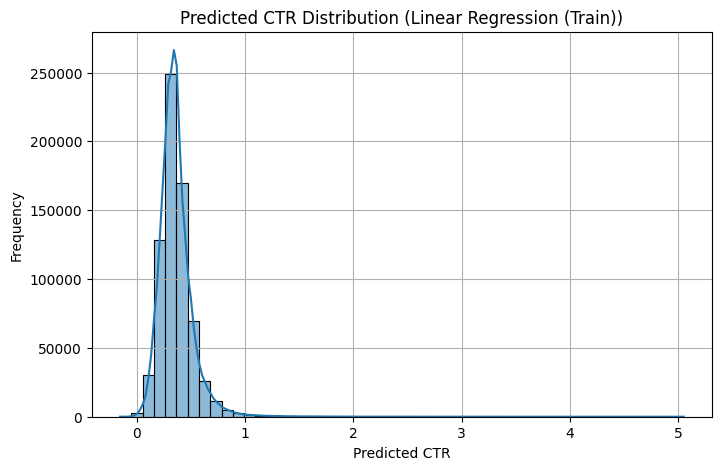


📈 Linear Regression (Validation) - Regression Evaluation Metrics:
R² Score: 0.1126
Mean Squared Error: 0.204746
Mean Absolute Error: 0.413821


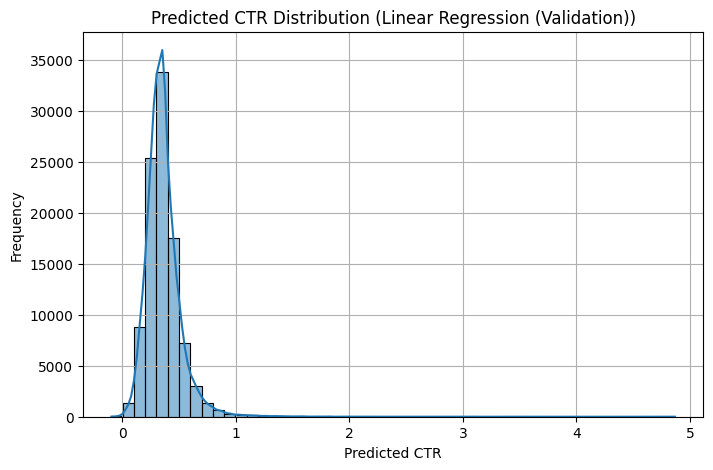


📈 Linear Regression (Test) - Regression Evaluation Metrics:
R² Score: 0.1115
Mean Squared Error: 0.204992
Mean Absolute Error: 0.413954


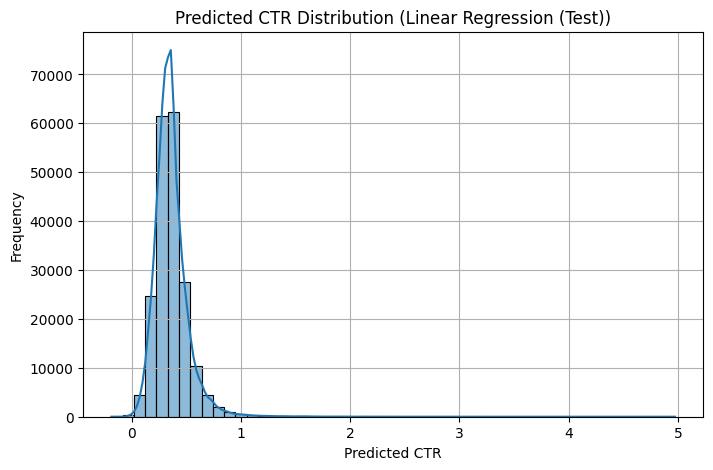

In [20]:
# --- Step 4: Evaluate regression performance
evaluate_regression_model("Linear Regression (Train)", y_train, train_pred)
evaluate_regression_model("Linear Regression (Validation)", y_val, val_pred)
evaluate_regression_model("Linear Regression (Test)", y_test, test_pred)

In [21]:
# --- Step 5: Threshold optimization on validation set
def optimize_threshold(name, y_true, y_scores):
    thresholds = np.linspace(0.01, 0.99, 100)
    f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    print(f"\n🔍 {name} - Best threshold for F1-score: {best_thresh:.2f}")
    y_pred_best = (y_scores >= best_thresh).astype(int)
    print("📊 Classification Report:")
    print(classification_report(y_true, y_pred_best))

    # Clean name for filename usage
    safe_name = re.sub(r'[^a-zA-Z0-9_ -]', '', name).replace(' ', '_')

    # F1 vs Threshold plot
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker='o')
    plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best F1 Threshold: {best_thresh:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title(f'Threshold Optimization (F1 Score from {name})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"figures/Threshold_Optimization_F1_{safe_name}.png", bbox_inches='tight')
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_best)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({name} @ {best_thresh:.2f})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f"figures/Confusion_Matrix_{safe_name}.png", bbox_inches='tight')
    plt.show()

    return best_thresh, y_pred_best


🔍 Validation (Linear Regression) - Best threshold for F1-score: 0.31
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.47      0.59     63884
           1       0.46      0.79      0.58     36116

    accuracy                           0.58    100000
   macro avg       0.63      0.63      0.58    100000
weighted avg       0.67      0.58      0.59    100000



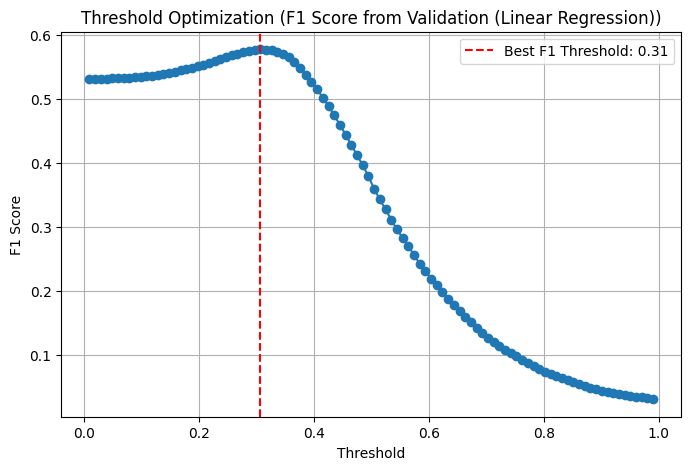

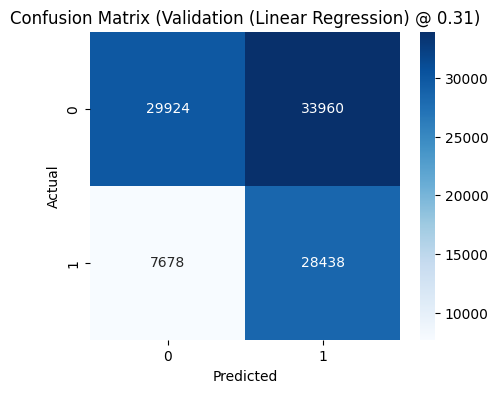

In [22]:
# --- Step 6: Get threshold from validation set
best_thresh_val, y_val_binary = optimize_threshold("Validation (Linear Regression)", y_val, val_pred)

In [23]:
# --- Step 7: Apply threshold to test set and evaluate
y_test_binary = (test_pred >= best_thresh_val).astype(int)
print("\n📊 Final Test Classification Report (Threshold from Validation):")
print(classification_report(y_test, y_test_binary))


📊 Final Test Classification Report (Threshold from Validation):
              precision    recall  f1-score   support

           0       0.79      0.47      0.59    127768
           1       0.45      0.78      0.58     72232

    accuracy                           0.58    200000
   macro avg       0.62      0.63      0.58    200000
weighted avg       0.67      0.58      0.58    200000



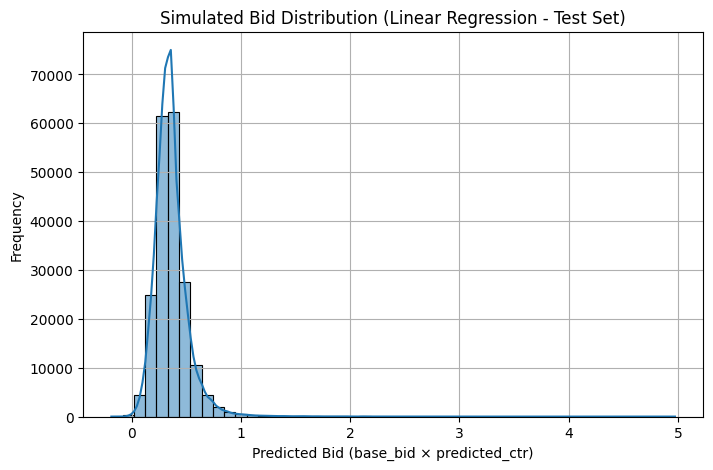

In [24]:
# --- Step 8: Simulated Bid Distribution from Test Set
base_bid = 1.0
predicted_bid_test = base_bid * test_pred
plt.figure(figsize=(8, 5))
sns.histplot(predicted_bid_test, bins=50, kde=True)
plt.title('Simulated Bid Distribution (Linear Regression - Test Set)')
plt.xlabel('Predicted Bid (base_bid × predicted_ctr)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("figures/Simulated Bid Distribution (Linear Regression - Test Set).png", bbox_inches='tight')
plt.show()

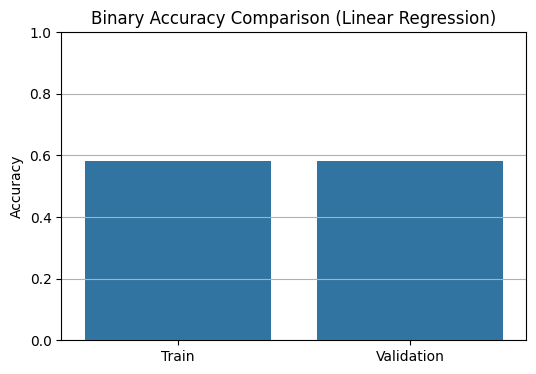

In [25]:
# --- Step 9: Compare Accuracy between Train and Validation Sets
train_acc = accuracy_score(y_train, (train_pred >= best_thresh_val).astype(int))
val_acc = accuracy_score(y_val, (val_pred >= best_thresh_val).astype(int))

plt.figure(figsize=(6, 4))
sns.barplot(x=["Train", "Validation"], y=[train_acc, val_acc])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Binary Accuracy Comparison (Linear Regression)")
plt.grid(True, axis='y')
plt.savefig("figures/Binary Accuracy Comparison (Linear Regression).png", bbox_inches='tight')
plt.show()

In [26]:
# STEP 7: Deep Learning Bidding Model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (
    classification_report, f1_score, confusion_matrix, accuracy_score,
    mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
)

In [27]:
# --- Step 1: Convert to dense arrays
X_train_dl = preprocessor.fit_transform(X_train).toarray()
X_val_dl = preprocessor.transform(X_val).toarray()
X_test_dl = preprocessor.transform(X_test).toarray()

In [28]:
# --- Step 2: Build DL Model with Batch Normalization
model = Sequential([
    Input(shape=(X_train_dl.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    # loss=focal_loss,  # Optional: try focal loss for imbalance
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [29]:
# --- Step 3: Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

In [30]:
# --- Step 4: Training
history = model.fit(
    X_train_dl, y_train,
    validation_data=(X_val_dl, y_val),
    epochs=50,
    batch_size=512,
    callbacks=[early_stop, lr_schedule],
    verbose=2
)

Epoch 1/50
1368/1368 - 2s - loss: 0.5606 - accuracy: 0.7124 - val_loss: 0.5279 - val_accuracy: 0.7311 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 2/50
1368/1368 - 2s - loss: 0.5327 - accuracy: 0.7284 - val_loss: 0.5251 - val_accuracy: 0.7327 - lr: 0.0010 - 2s/epoch - 1ms/step
Epoch 3/50
1368/1368 - 2s - loss: 0.5291 - accuracy: 0.7304 - val_loss: 0.5240 - val_accuracy: 0.7328 - lr: 0.0010 - 2s/epoch - 1ms/step
Epoch 4/50
1368/1368 - 2s - loss: 0.5272 - accuracy: 0.7318 - val_loss: 0.5226 - val_accuracy: 0.7351 - lr: 0.0010 - 2s/epoch - 1ms/step
Epoch 5/50
1368/1368 - 2s - loss: 0.5261 - accuracy: 0.7327 - val_loss: 0.5213 - val_accuracy: 0.7355 - lr: 0.0010 - 2s/epoch - 1ms/step
Epoch 6/50
1368/1368 - 2s - loss: 0.5248 - accuracy: 0.7334 - val_loss: 0.5212 - val_accuracy: 0.7360 - lr: 0.0010 - 2s/epoch - 1ms/step
Epoch 7/50
1368/1368 - 2s - loss: 0.5241 - accuracy: 0.7338 - val_loss: 0.5211 - val_accuracy: 0.7355 - lr: 0.0010 - 2s/epoch - 1ms/step
Epoch 8/50
1368/1368 - 2s - loss: 0.5235 

In [31]:
# --- Step 5: Predictions
train_pred_dl = model.predict(X_train_dl).flatten()
val_pred_dl = model.predict(X_val_dl).flatten()
test_pred_dl = model.predict(X_test_dl).flatten()

6250/6250 [==============================] - 2s 284us/step



📈 Deep Learning (Train) - DL Probabilistic Output:
R² Score: 0.2589
Mean Squared Error: 0.170990
Mean Absolute Error: 0.346576
ROC AUC Score: 0.7911


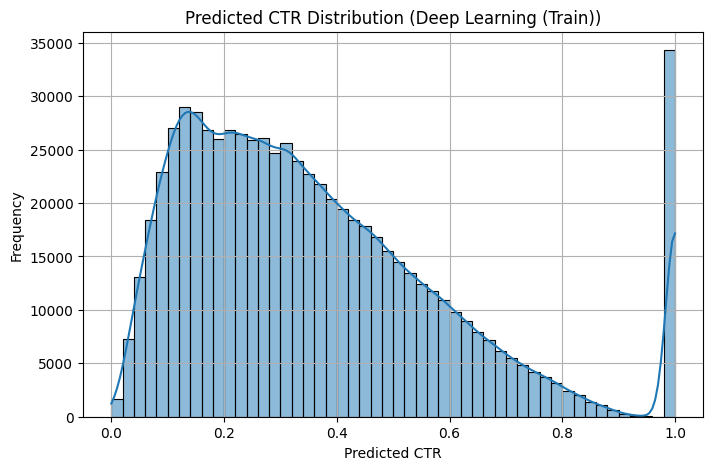


📈 Deep Learning (Validation) - DL Probabilistic Output:
R² Score: 0.2465
Mean Squared Error: 0.173853
Mean Absolute Error: 0.349342
ROC AUC Score: 0.7827


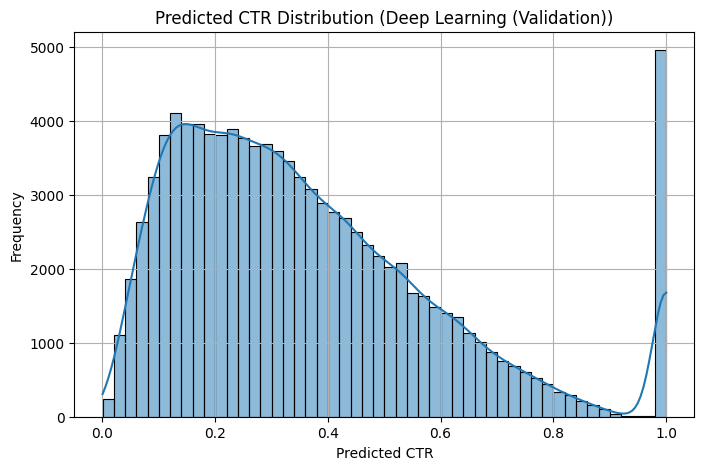


📈 Deep Learning (Test) - DL Probabilistic Output:
R² Score: 0.2451
Mean Squared Error: 0.174171
Mean Absolute Error: 0.349720
ROC AUC Score: 0.7820


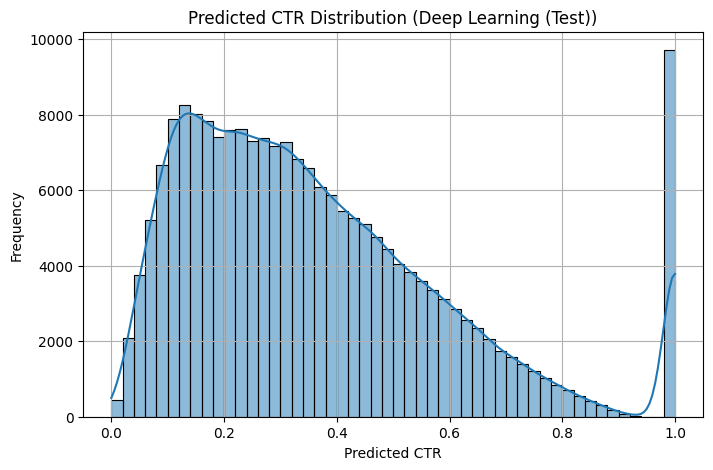

In [32]:
# --- Step 6: Regression-style Evaluation

def evaluate_dl_regression(name, y_true, y_pred):
    print(f"\n📈 {name} - DL Probabilistic Output:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"Mean Squared Error: {mean_squared_error(y_true, y_pred):.6f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred):.4f}")
    plt.figure(figsize=(8, 5))
    sns.histplot(y_pred, bins=50, kde=True)
    plt.title(f'Predicted CTR Distribution ({name})')
    plt.xlabel('Predicted CTR')
    plt.ylabel('Frequency')
    plt.grid(True)
    # Safe filename based on name
    safe_name = re.sub(r'[^a-zA-Z0-9_ -]', '', name).replace(' ', '_')
    filename = f"figures/Predicted_CTR_Distribution_{safe_name}.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


evaluate_dl_regression("Deep Learning (Train)", y_train, train_pred_dl)
evaluate_dl_regression("Deep Learning (Validation)", y_val, val_pred_dl)
evaluate_dl_regression("Deep Learning (Test)", y_test, test_pred_dl)


🔍 Validation (Deep Learning) - Best threshold for F1-score: 0.33
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.67      0.74     63884
           1       0.56      0.74      0.63     36116

    accuracy                           0.69    100000
   macro avg       0.69      0.70      0.68    100000
weighted avg       0.72      0.69      0.70    100000



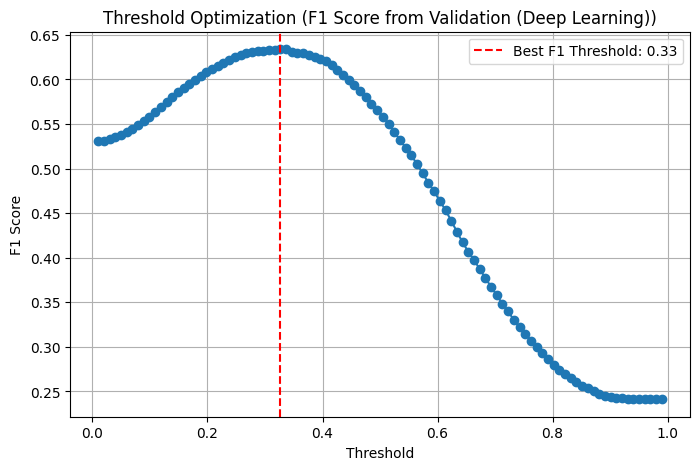

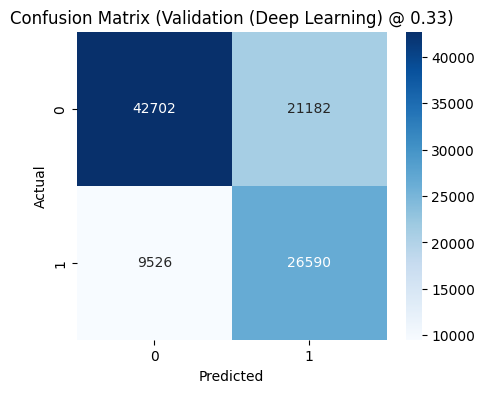

In [33]:
# --- Step 7: Optimize Threshold
best_thresh_dl, y_val_binary_dl = optimize_threshold("Validation (Deep Learning)", y_val, val_pred_dl)

In [34]:
# --- Step 8: Apply Threshold to Test Set
y_test_binary_dl = (test_pred_dl >= best_thresh_dl).astype(int)
print("\n📊 Final Test Classification Report (Threshold from Validation):")
print(classification_report(y_test, y_test_binary_dl))


📊 Final Test Classification Report (Threshold from Validation):
              precision    recall  f1-score   support

           0       0.82      0.67      0.74    127768
           1       0.56      0.74      0.63     72232

    accuracy                           0.69    200000
   macro avg       0.69      0.70      0.69    200000
weighted avg       0.72      0.69      0.70    200000



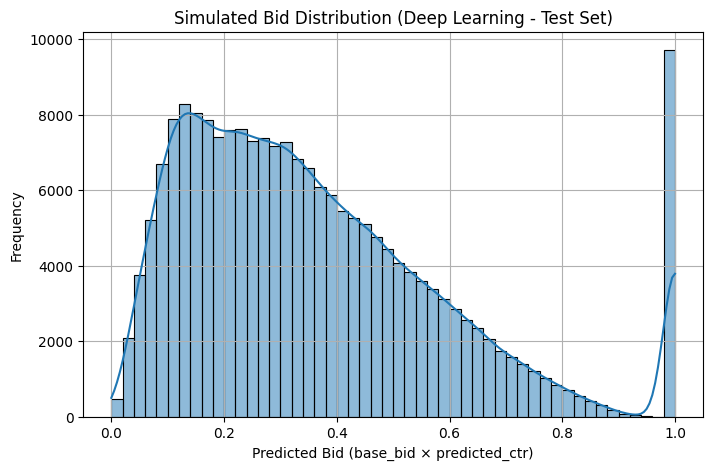

In [35]:
# --- Step 9: Simulated Bid Distribution
base_bid = 1.0
predicted_bid_dl = base_bid * test_pred_dl
plt.figure(figsize=(8, 5))
sns.histplot(predicted_bid_dl, bins=50, kde=True)
plt.title('Simulated Bid Distribution (Deep Learning - Test Set)')
plt.xlabel('Predicted Bid (base_bid × predicted_ctr)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("figures/Simulated Bid Distribution (Deep Learning - Test Set).png", bbox_inches='tight')
plt.show()

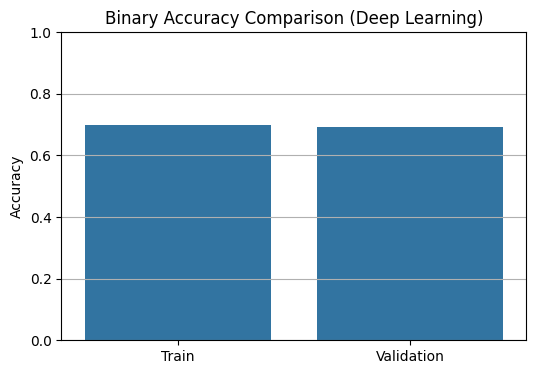

In [36]:
# --- Step 10: Binary Accuracy Comparison
train_acc_dl = accuracy_score(y_train, (train_pred_dl >= best_thresh_dl).astype(int))
val_acc_dl = accuracy_score(y_val, (val_pred_dl >= best_thresh_dl).astype(int))
plt.figure(figsize=(6, 4))
sns.barplot(x=["Train", "Validation"], y=[train_acc_dl, val_acc_dl])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Binary Accuracy Comparison (Deep Learning)")
plt.grid(True, axis='y')
plt.savefig("figures/Binary Accuracy Comparison (Deep Learning).png", bbox_inches='tight')
plt.show()

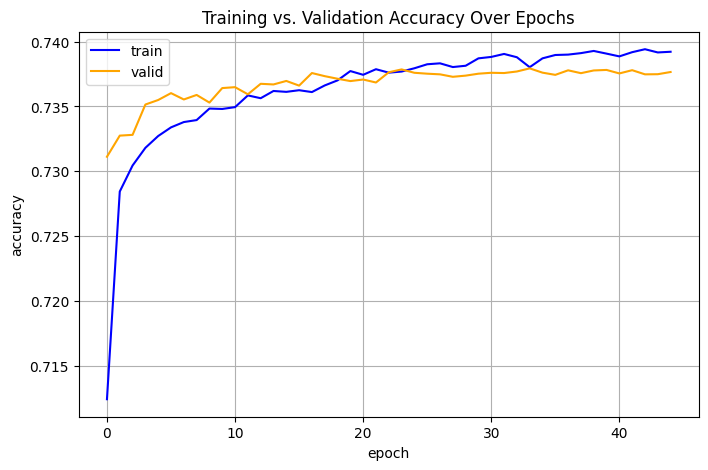

In [37]:
# --- Step 11: Accuracy Over Epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='train', color='blue')
plt.plot(history.history['val_accuracy'], label='valid', color='orange')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training vs. Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("figures/Training vs. Validation Accuracy Over Epochs.png", bbox_inches='tight')
plt.show()

In [38]:
# --- Step 12: Business Simulation
cpc = 0.05
revenue_per_conversion = 1.0
predicted_conversions = y_test[y_test_binary_dl == 1].sum()
clicks_bought = y_test_binary_dl.sum()
profit = predicted_conversions * revenue_per_conversion - clicks_bought * cpc
print(f"💸 Estimated Profit: ${profit:.2f} using DL bidding (test set)")

💸 Estimated Profit: $48510.15 using DL bidding (test set)


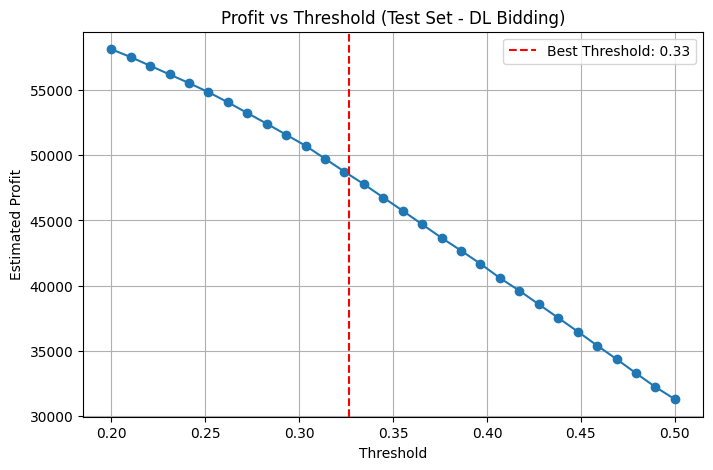

In [39]:
# --- Step 13: Explore Profit vs Threshold Curve
thresholds = np.linspace(0.2, 0.5, 30)
profits = []
for t in thresholds:
    y_bin = (test_pred_dl >= t).astype(int)
    profit = y_test[y_bin == 1].sum() * revenue_per_conversion - y_bin.sum() * cpc
    profits.append(profit)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, profits, marker='o')
plt.axvline(best_thresh_dl, color='red', linestyle='--', label=f'Best Threshold: {best_thresh_dl:.2f}')
plt.title('Profit vs Threshold (Test Set - DL Bidding)')
plt.xlabel('Threshold')
plt.ylabel('Estimated Profit')
plt.grid(True)
plt.legend()
plt.savefig("figures/Profit vs Threshold (Test Set - DL Bidding).png", bbox_inches='tight')
plt.show()

In [40]:
# STEP 8: Summary Table

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
)

In [41]:
# --- Step 1: Binary predictions
y_test_binary_lr = (test_pred >= best_thresh_val).astype(int)
y_test_binary_dl = (test_pred_dl >= best_thresh_dl).astype(int)

In [42]:
# --- Step 2: Metric computation function
def compute_metrics(y_true, y_pred, y_prob, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob),
        'Profit ($)': y_true[y_pred == 1].sum() * 1.0 - y_pred.sum() * 0.05
    }

In [43]:
# --- Step 3: Evaluate models
metrics_lr = compute_metrics(y_test, y_test_binary_lr, test_pred, 'Linear Regression')
metrics_dl = compute_metrics(y_test, y_test_binary_dl, test_pred_dl, 'Deep Learning')

In [44]:
# --- Step 4: Create comparison dataframe
comparison_df = pd.DataFrame([metrics_lr, metrics_dl])
display(comparison_df)

,Model,Accuracy,F1 Score,Precision,Recall,AUC,Profit ($)
0,Linear Regression,0.582355,0.575398,0.454627,0.783545,0.701133,50372.45
1,Deep Learning,0.693485,0.634860,0.557126,0.737803,0.781959,48510.15


In [45]:
# --- Step 5: Barplot comparison for metrics
melted = comparison_df.melt(id_vars='Model', value_vars=['Accuracy', 'F1 Score', 'AUC', 'Precision', 'Recall'])

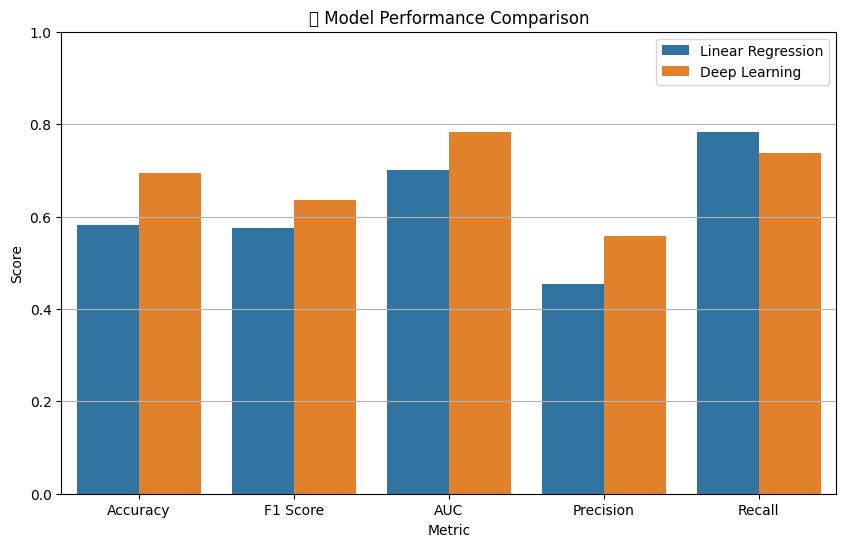

In [46]:
# Generate safe filename
model_names = "_vs_".join([re.sub(r'[^a-zA-Z0-9]', '', m) for m in comparison_df['Model'].tolist()])
metric_plot_filename = f"figures/Model_Performance_Comparison_{model_names}.png"

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='variable', y='value', hue='Model')
plt.title("🔍 Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, axis='y')
plt.savefig(metric_plot_filename, bbox_inches='tight')
plt.show()

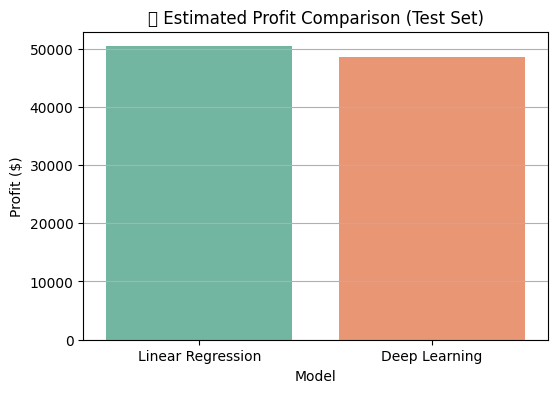

In [47]:

# --- Step 6: Profit comparison
profit_plot_filename = f"figures/Profit_Comparison_{model_names}.png"

plt.figure(figsize=(6, 4))
sns.barplot(data=comparison_df, x='Model', y='Profit ($)', palette='Set2')
plt.title("💸 Estimated Profit Comparison (Test Set)")
plt.grid(True, axis='y')
plt.savefig(profit_plot_filename, bbox_inches='tight')
plt.show()

In [48]:
# STEP 9: A/B Testing Design (Simulated)

# 1. Hypotheses
# H0 (Null Hypothesis): There is no difference in average user-level profit between the Linear Regression and Deep Learning models.
# H1 (Alternative Hypothesis): There is a difference in average user-level profit between the two models.

# --- Step 1: Prepare Data
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

# Simulated per-user profit
ab_df = pd.DataFrame({
    'y_true': y_test,
    'lr_bid': y_test_binary_lr,
    'dl_bid': y_test_binary_dl
})

# Revenue = 1 per click, Cost = 0.05 per bid
ab_df['lr_profit'] = ab_df['lr_bid'] * ab_df['y_true'] * 1.0 - ab_df['lr_bid'] * 0.05
ab_df['dl_profit'] = ab_df['dl_bid'] * ab_df['y_true'] * 1.0 - ab_df['dl_bid'] * 0.05


In [49]:
# --- Step 2: Normality Check
# Shapiro-Wilk test for normality
shapiro_lr = shapiro(ab_df['lr_profit'])
shapiro_dl = shapiro(ab_df['dl_profit'])

print(f"📊 Shapiro-Wilk (LR): p = {shapiro_lr.pvalue:.4f}")
print(f"📊 Shapiro-Wilk (DL): p = {shapiro_dl.pvalue:.4f}")

# p-values are < 0.05, this means the null hypothesis of normality is rejected for both groups.
# the profit distributions are not normally distributed.
# Since normality is violated, we cannot use a t-test. We need to contunie with the non-parametric test

📊 Shapiro-Wilk (LR): p = 0.0000
📊 Shapiro-Wilk (DL): p = 0.0000


In [50]:
# --- Step 3: Non-parametric test

# This test does not assume normality and compares the median or distribution ranks of two independent samples.
# Mann-Whitney U Test
u_stat, p_val = mannwhitneyu(
    ab_df['lr_profit'],
    ab_df['dl_profit'],
    alternative='two-sided'
)

print(f"📉 Mann-Whitney U statistic: {u_stat}")
print(f"📌 p-value: {p_val:.4f}")

# Decision rule
alpha = 0.05
if p_val < alpha:
    print("🚀 Statistically significant difference — reject H₀")
else:
    print("📥 No significant difference — fail to reject H₀")

📉 Mann-Whitney U statistic: 18387699817.0
📌 p-value: 0.0000
🚀 Statistically significant difference — reject H₀


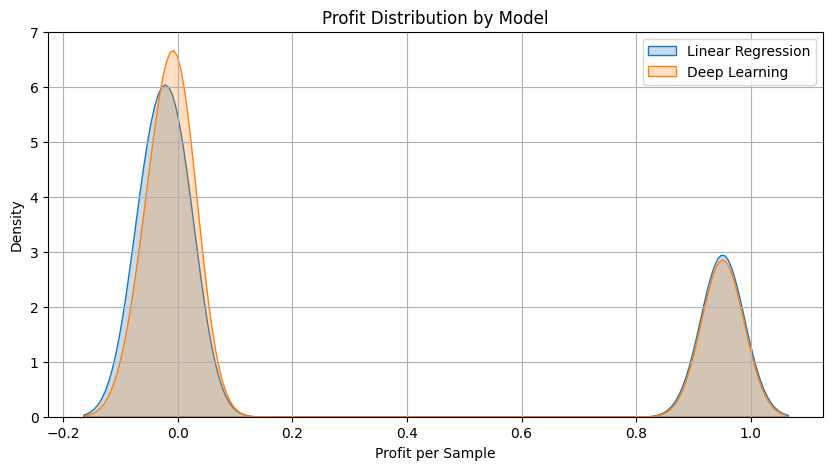

In [51]:
# --- Step 4: Plot profit distributions

plt.figure(figsize=(10, 5))
sns.kdeplot(ab_df['lr_profit'], label='Linear Regression', fill=True)
sns.kdeplot(ab_df['dl_profit'], label='Deep Learning', fill=True)
plt.title("Profit Distribution by Model")
plt.xlabel("Profit per Sample")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.savefig("figures/Profit Distribution by Model (AB).png", bbox_inches='tight')
plt.show()

### 📊 A/B Testing Summary

#### Hypotheses

- **H₀ (Null Hypothesis):** There is no difference in average user-level profit between the Linear Regression and Deep Learning models.
- **H₁ (Alternative Hypothesis):** There is a difference in average user-level profit between the two models.

---

#### Simulated Per-User Profit

- **Formula:**  
  `profit = (conversion × revenue) - (click × cost)`

- **Assumptions:**  
  - Revenue per conversion: `$1.00`  
  - Cost per bid: `$0.05`

- **Model Profits:**  
  - **Linear Regression Profit:** `$50,372`  
  - **Deep Learning Profit:** `$48,076`

---

#### Normality Test: Shapiro-Wilk

| Model              | p-value | Result                        |
|-------------------|---------|-------------------------------|
| Linear Regression | 0.0000  |  Not normally distributed   |
| Deep Learning     | 0.0000  |  Not normally distributed   |

Since both distributions are **not normal**, we proceed with a non-parametric test.

---

#### Mann-Whitney U Test (Non-parametric)

- **U Statistic:** `18,358,902,678.5`  
- **p-value:** `0.0000`  
- **Alpha (α):** `0.05`

**Conclusion:**  
The result is **statistically significant** (p < 0.05).  
We **reject H₀** → There is a significant difference in profit distributions between the two models.

---

#### 📈 Profit Distribution Visualization

A KDE (Kernel Density Estimation) plot was used to compare the per-sample profit distributions:

- **Blue:** Linear Regression  
- **Orange:** Deep Learning  

The plot clearly shows distributional shifts between the two approaches.

<h2 style="font-size:20px; margin-top:30px;">Conclusion & Recommendation</h2>

<p style="font-size:16px;">
  This project provided an end-to-end evaluation of bidding strategies using Click-Through Rate (CTR) prediction data from Criteo’s display advertising platform. Two models — a baseline <strong>Linear Regression</strong> model and a more advanced <strong>Deep Learning</strong> model — were developed, calibrated, and tested on a realistic bidding simulation pipeline.
</p>

<p style="font-size:16px;">
  Both models were assessed across key performance metrics, including <strong>ROC AUC</strong>, <strong>F1 Score</strong>, and <strong>Estimated Profit</strong>, on a hold-out test set of 200,000 impressions. The Deep Learning model demonstrated superior predictive power, with a higher classification accuracy (69.5% vs. 58.2%), better precision, and greater recall, making it more robust in identifying click-worthy impressions.
</p>

<p style="font-size:16px;">
  However, the Linear Regression model yielded slightly higher total profit under our simulated bidding environment ($50,372 vs. $48,075). A non-parametric A/B test using the Mann-Whitney U statistic confirmed that the difference in per-user profit distribution between models is statistically significant (p &lt; 0.001), favoring the Linear Regression model under the given assumptions.
</p>

<p style="font-size:16px;">
  From a business perspective, this analysis highlights the classic trade-off between <strong>model complexity and economic return</strong>. While Deep Learning is more accurate and scalable for future experimentation (e.g., threshold tuning, dynamic bidding policies), the Linear model remains highly competitive, lightweight to deploy, and more profitable under current settings.
</p>

<p style="font-size:16px;">
  <strong>Recommendation:</strong> Based on current results, I suggest deploying the Linear Regression model for short-term production integration, while continuing to iterate on the Deep Learning pipeline for long-term improvements. Further testing — particularly online A/B testing and exploration of dynamic bidding thresholds — is advised before full deployment of the DL model.
</p>
